# Part 3: Data Serving with SQL and MLlib (Gold Layer)

## Overview
This notebook implements the **Gold Layer** of the Medallion Architecture, creating analytics-ready datasets for energy consumption optimization using **SQL and MLlib**.

## Requirements
**This part uses SQL, MLlib, and high-level APIs for analytics and serving (no MapReduce/RDD).**

## Business Use Case: Energy Consumption Optimization
**Goal**: Optimize residential energy consumption by analyzing patterns, predicting demand, and identifying efficiency opportunities.

**Key Business Questions**:
1. How does weather (temperature, humidity, solar radiation) correlate with energy consumption?
2. Can we predict energy consumption based on weather conditions?
3. What are peak consumption periods and how do they relate to weather?
4. How can we cluster households by consumption patterns for targeted efficiency programs?

## Objectives
1. **Weather-Energy Integration**: Join weather data with energy consumption data
2. **Business Metrics**: Calculate daily/hourly consumption patterns, peak demand analysis
3. **Predictive Analytics**: Build ML models to predict consumption based on weather
4. **Clustering**: Identify household consumption patterns using K-Means
5. **Performance Profiling**: Measure and optimize SQL/MLlib operations
6. **Data Serving**: Prepare analytics-ready datasets for dashboards/apps

## Medallion Architecture: Gold Layer
- **Input**: Cleaned data from Silver layer (`silver_data/`) + Weather data (`weather_dataset/`)
- **Processing**: SQL aggregations, MLlib algorithms (regression, clustering)
- **Output**: Analytics-ready datasets in `gold_data/` for dashboard/app consumption


In [1]:
# Setup and Imports
import time
from datetime import datetime, timedelta
import findspark

findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark Session
# Note: Memory settings are optional
spark = SparkSession.builder \
    .appName("Part3-DataServing-Analytics") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memoryFraction", "0.8") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("Spark session initialized")
print(f"Spark version: {spark.version}")
print(f"SQL functions available: Yes")
print(f"MLlib available: Yes")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/12 22:20:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session initialized
Spark version: 3.5.0
SQL functions available: Yes
MLlib available: Yes


## Step 1: Load Data from Silver Layer and Weather Dataset

Load cleaned energy consumption data from Silver layer and weather data for integration.


In [2]:
# Load cleaned data from Silver layer (JSON Lines format)
silver_data_path = "../Part2_Data_Cleaning/silver_data/"

print("Loading cleaned energy consumption data from Silver layer...")
silver_df = spark.read.json(f"{silver_data_path}/*")

# Convert datetime string to timestamp
silver_df = silver_df.withColumn("datetime", to_timestamp(col("datetime"), "yyyy-MM-dd HH:mm:ss"))

print("Loaded cleaned data from Silver layer")
print(f"Record count: {silver_df.count():,}")
print(f"Columns: {silver_df.columns}")
silver_df.printSchema()
silver_df.show(10, truncate=False)

# Load weather data
weather_data_path = "../weather_dataset/"

print("\nLoading weather data...")
print("Note: Weather data is already clean CSV format, no Part 2 cleaning needed.")
weather_files = [
    f"{weather_data_path}Lahore.csv",
    f"{weather_data_path}Karachi.csv",
    f"{weather_data_path}Multan.csv",
    f"{weather_data_path}Peshawar.csv",
    f"{weather_data_path}Islamabad.csv",
    f"{weather_data_path}Skardu.csv"
]

# Read all weather CSV files and union them
weather_dfs = []
for file in weather_files:
    city_name = file.split("/")[-1].replace(".csv", "")
    df = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .csv(file)
    df = df.withColumn("city", lit(city_name))
    weather_dfs.append(df)

weather_df = weather_dfs[0]
for df in weather_dfs[1:]:
    weather_df = weather_df.union(df)

# Clean and standardize weather data
weather_df = weather_df \
    .withColumn("datetime", to_timestamp(col("datetime"), "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("Temperature", col("Temperature").cast("double")) \
    .withColumn("Humidity", col("Humidity").cast("double")) \
    .withColumn("Wind Speed", col("Wind Speed").cast("double")) \
    .withColumn("Solar Radiation", col("Solar Radiation").cast("double")) \
    .withColumn("Solar Energy", col("Solar Energy").cast("double")) \
    .withColumn("UV Index", col("UV Index").cast("int")) \
    .withColumn("Pressure", col("Pressure").cast("double"))

print("Loaded weather data")
print(f"Weather record count: {weather_df.count():,}")
print(f"Weather columns: {weather_df.columns}")
weather_df.printSchema()
weather_df.show(10, truncate=False)


Loading cleaned energy consumption data from Silver layer...


Loaded cleaned data from Silver layer


Record count: 27,986,366
Columns: ['city', 'datetime', 'source_file', 'usage_kw']
root
 |-- city: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- source_file: string (nullable = true)
 |-- usage_kw: double (nullable = true)

+---------+-------------------+---------------------+--------+
|city     |datetime           |source_file          |usage_kw|
+---------+-------------------+---------------------+--------+
|Islamabad|2023-11-05 08:04:00|islamabad_House41.csv|0.52    |
|Islamabad|2023-11-12 10:48:00|islamabad_House41.csv|0.61    |
|Islamabad|2023-11-17 08:06:00|islamabad_House41.csv|0.0     |
|Islamabad|2023-11-17 08:09:00|islamabad_House41.csv|0.0     |
|Islamabad|2023-11-17 18:44:00|islamabad_House41.csv|0.6     |
|Islamabad|2023-11-24 00:09:00|islamabad_House41.csv|0.94    |
|Islamabad|2023-11-27 02:44:00|islamabad_House41.csv|1.03    |
|Islamabad|2023-11-29 08:09:00|islamabad_House41.csv|1.25    |
|Islamabad|2023-12-02 10:41:00|islamabad_House41.csv|0.79

## Step 2: Weather-Energy Data Integration

Join weather data with energy consumption data to enable weather-based analytics.


In [3]:
# Step 2: Join energy consumption with weather data
# Join on datetime (rounded to hour) and city
print("Joining energy consumption data with weather data...")

# First, check city names in both datasets
print("\nChecking city names in energy data:")
silver_df.select("city").distinct().orderBy("city").show()

print("\nChecking city names in weather data:")
weather_df.select("city").distinct().orderBy("city").show()

# Normalize city names for both datasets (lowercase for matching)
energy_hourly = silver_df \
    .withColumn("city_normalized", lower(trim(col("city")))) \
    .withColumn("date_hour", date_format(col("datetime"), "yyyy-MM-dd HH:00:00")) \
    .withColumn("date_hour_ts", to_timestamp(col("date_hour"), "yyyy-MM-dd HH:00:00"))

weather_hourly = weather_df \
    .withColumn("city_normalized", lower(trim(col("city")))) \
    .withColumn("date_hour", date_format(col("datetime"), "yyyy-MM-dd HH:00:00")) \
    .withColumn("date_hour_ts", to_timestamp(col("date_hour"), "yyyy-MM-dd HH:00:00"))

# Join on hour and normalized city name
joined_df = energy_hourly \
    .join(
        weather_hourly.select(
            col("date_hour_ts").alias("weather_hour"),
            col("city_normalized").alias("weather_city"),
            col("Temperature"),
            col("Humidity"),
            col("Wind Speed"),
            col("Solar Radiation"),
            col("Solar Energy"),
            col("UV Index"),
            col("Pressure")
        ),
        (col("date_hour_ts") == col("weather_hour")) & 
        (col("city_normalized") == col("weather_city")),
        "inner"
    ) \
    .drop("date_hour", "weather_hour", "weather_city", "city_normalized")

# Cache the joined dataset for multiple uses
joined_df.cache()

print("\nJoined energy and weather data")
print(f"Joined record count: {joined_df.count():,}")
print("\nSample joined data:")
joined_df.select("datetime", "city", "usage_kw", "Temperature", "Humidity", "Solar Radiation").show(10, truncate=False)

# Register as temporary view for SQL queries
# IMPORTANT: Create views BEFORE running SQL queries
joined_df.createOrReplaceTempView("energy_weather")
silver_df.createOrReplaceTempView("energy_data")

print("\nTemporary views created:")
print("  - energy_data: Silver layer energy consumption data")
print("  - energy_weather: Joined energy and weather data")
print("\nReady for SQL queries in next step!")


Joining energy consumption data with weather data...

Checking city names in energy data:


+---------+
|     city|
+---------+
|Islamabad|
|  Karachi|
|   Lahore|
|   Multan|
| Peshawar|
|   Skardu|
+---------+


Checking city names in weather data:
+---------+
|     city|
+---------+
|Islamabad|
|  Karachi|
|   Lahore|
|   Multan|
| Peshawar|
|   Skardu|
+---------+


Joined energy and weather data


25/11/12 22:22:05 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 45.5 MiB so far)
25/11/12 22:22:05 WARN BlockManager: Persisting block rdd_170_11 to disk instead.
25/11/12 22:22:09 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:22:09 WARN BlockManager: Persisting block rdd_170_8 to disk instead.
25/11/12 22:22:10 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:22:11 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:22:13 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 23.1 MiB so far)
25/11/12 22:22:13 WARN BlockManager: Persisting block rdd_170_12 to disk instead.
25/11/12 22:22:14 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 23.1 MiB so far)
25/11/12 22:22:14 WARN BlockManager: Persisting block rdd_170_15 to disk instead.
25/11/12 

Joined record count: 27,986,366

Sample joined data:
+-------------------+---------+--------+-----------+--------+---------------+
|datetime           |city     |usage_kw|Temperature|Humidity|Solar Radiation|
+-------------------+---------+--------+-----------+--------+---------------+
|2023-11-05 08:04:00|Islamabad|0.52    |14.2       |66.64   |225.0          |
|2023-11-12 10:48:00|Islamabad|0.61    |19.3       |55.97   |468.2          |
|2023-11-17 08:06:00|Islamabad|0.0     |13.5       |67.12   |176.0          |
|2023-11-17 08:09:00|Islamabad|0.0     |13.5       |67.12   |176.0          |
|2023-11-17 18:44:00|Islamabad|0.6     |18.2       |69.81   |0.0            |
|2023-11-24 00:09:00|Islamabad|0.94    |13.4       |88.27   |0.0            |
|2023-11-27 02:44:00|Islamabad|1.03    |13.4       |66.0    |0.0            |
|2023-11-29 08:09:00|Islamabad|1.25    |11.8       |68.98   |128.0          |
|2023-12-02 10:41:00|Islamabad|0.79    |19.6       |48.68   |393.2          |
|2023-12-02

## Step 3: Business Metrics with SQL

Calculate energy consumption metrics and weather correlations using Spark SQL.


In [4]:
# Verify temporary views exist (create if they don't)
print("Verifying temporary views...")
try:
    spark.sql("SELECT 1 FROM energy_data LIMIT 1").show()
    spark.sql("SELECT 1 FROM energy_weather LIMIT 1").show()
    print("Temporary views verified\n")
except Exception as e:
    print(f"Views not found. Creating them now...")
    # Create views if they don't exist
    try:
        silver_df.createOrReplaceTempView("energy_data")
        print("Created energy_data view")
    except:
        pass
    
    # Check if joined_df exists, if not, we need to run Step 2
    try:
        joined_df.createOrReplaceTempView("energy_weather")
        print("Created energy_weather view")
    except NameError:
        print("ERROR: joined_df does not exist!")
        print("Please run Step 2 (Weather-Energy Data Integration) cell first!")
        print("Step 2 creates the joined_df and temporary views.")
        raise NameError("joined_df not found. Please run Step 2 first.")
    except:
        pass
    
    print("Temporary views ready\n")

# 1. Daily Energy Consumption Summary
print("=== Daily Energy Consumption Summary ===")
daily_metrics = spark.sql("""
    SELECT 
        DATE(datetime) as date,
        city,
        COUNT(*) as total_readings,
        SUM(usage_kw) as total_consumption_kw,
        AVG(usage_kw) as avg_consumption_kw,
        MAX(usage_kw) as peak_consumption_kw,
        MIN(usage_kw) as min_consumption_kw,
        STDDEV(usage_kw) as stddev_consumption_kw
    FROM energy_data
    WHERE datetime IS NOT NULL
    GROUP BY DATE(datetime), city
    ORDER BY date DESC, total_consumption_kw DESC
""")

daily_metrics.show(20)

# 2. Hourly Consumption Patterns
print("\n=== Hourly Consumption Patterns ===")
hourly_patterns = spark.sql("""
    SELECT 
        HOUR(datetime) as hour_of_day,
        city,
        AVG(usage_kw) as avg_consumption_kw,
        MAX(usage_kw) as peak_consumption_kw,
        COUNT(*) as reading_count
    FROM energy_data
    WHERE datetime IS NOT NULL
    GROUP BY HOUR(datetime), city
    ORDER BY hour_of_day, avg_consumption_kw DESC
""")

hourly_patterns.show(24)

# 3. Weather-Energy Correlation Analysis
print("\n=== Weather-Energy Correlation Analysis ===")
weather_correlation = spark.sql("""
    SELECT 
        city,
        AVG(Temperature) as avg_temperature,
        AVG(Humidity) as avg_humidity,
        AVG(`Solar Radiation`) as avg_solar_radiation,
        AVG(usage_kw) as avg_consumption_kw,
        CORR(Temperature, usage_kw) as temp_consumption_corr,
        CORR(Humidity, usage_kw) as humidity_consumption_corr,
        CORR(`Solar Radiation`, usage_kw) as solar_consumption_corr,
        COUNT(*) as data_points
    FROM energy_weather
    WHERE Temperature IS NOT NULL AND usage_kw IS NOT NULL
    GROUP BY city
    ORDER BY avg_consumption_kw DESC
""")

weather_correlation.show(10, truncate=False)

# 4. Peak Demand Analysis by Temperature Ranges
print("\n=== Peak Demand Analysis by Temperature Ranges ===")
peak_demand = spark.sql("""
    SELECT 
        CASE 
            WHEN Temperature < 20 THEN 'Cold (<20°C)'
            WHEN Temperature < 25 THEN 'Mild (20-25°C)'
            WHEN Temperature < 30 THEN 'Warm (25-30°C)'
            WHEN Temperature < 35 THEN 'Hot (30-35°C)'
            ELSE 'Very Hot (≥35°C)'
        END as temperature_range,
        AVG(usage_kw) as avg_consumption_kw,
        MAX(usage_kw) as peak_consumption_kw,
        COUNT(*) as reading_count,
        AVG(Temperature) as avg_temp_in_range
    FROM energy_weather
    WHERE Temperature IS NOT NULL AND usage_kw IS NOT NULL
    GROUP BY temperature_range
    ORDER BY avg_consumption_kw DESC
""")

peak_demand.show(10, truncate=False)

# 5. Household Consumption Summary (by source_file)
print("\n=== Household Consumption Summary ===")
household_summary = spark.sql("""
    SELECT 
        city,
        source_file,
        COUNT(*) as total_readings,
        AVG(usage_kw) as avg_consumption_kw,
        MAX(usage_kw) as peak_consumption_kw,
        SUM(usage_kw) as total_consumption_kw,
        MIN(datetime) as first_reading,
        MAX(datetime) as last_reading
    FROM energy_data
    WHERE source_file IS NOT NULL
    GROUP BY city, source_file
    ORDER BY avg_consumption_kw DESC
""")

household_summary.show(20, truncate=False)


Verifying temporary views...
+---+
|  1|
+---+
|  1|
+---+

+---+
|  1|
+---+
|  1|
+---+

Temporary views verified

=== Daily Energy Consumption Summary ===


+----------+------+--------------+--------------------+--------------------+-------------------+------------------+---------------------+
|      date|  city|total_readings|total_consumption_kw|  avg_consumption_kw|peak_consumption_kw|min_consumption_kw|stddev_consumption_kw|
+----------+------+--------------+--------------------+--------------------+-------------------+------------------+---------------------+
|2024-11-28|Skardu|           829|  189.29242339800004| 0.22833826706634505|        2.912083334|       0.001016667|   0.6069427158521811|
|2024-11-27|Skardu|          1440|  103.17101644499999| 0.07164653919791666|             2.4313|         8.3333E-5|  0.34507583589475854|
|2024-11-26|Skardu|          1440|  224.88898359900008| 0.15617290527708338|        2.661233334|         8.3333E-5|   0.4926531795318554|
|2024-11-25|Skardu|          1440|  19.421433661000005|0.013487106709027781|             2.3474|       0.002150001|  0.16187681020871872|
|2024-11-24|Skardu|          1440|

25/11/12 22:23:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+---------+-------------------+-------------------+-------------+
|hour_of_day|     city| avg_consumption_kw|peak_consumption_kw|reading_count|
+-----------+---------+-------------------+-------------------+-------------+
|          0|  Karachi|  1.222622352949102|             9.8831|       217689|
|          0|   Lahore| 1.1115642528912908|        9.413166667|       183420|
|          0|   Multan| 0.9052074909277377|            9.06285|       216961|
|          0| Peshawar|  0.749366640929694|             9.8413|       209401|
|          0|Islamabad| 0.5880166010302537|               8.37|       206553|
|          0|   Skardu|0.15268167464066426|             3.5292|       132581|
|          1|  Karachi| 1.2237820686924092|        8.651700001|       217744|
|          1|   Lahore| 1.0103917716224624|       10.165666667|       184002|
|          1|   Multan|  0.856750523551472|             7.4686|       216960|
|          1| Peshawar|  0.724199507912225|        8.875983333| 

25/11/12 22:23:36 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 45.5 MiB so far)
25/11/12 22:23:36 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 11.9 MiB so far)
25/11/12 22:23:36 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 11.9 MiB so far)
25/11/12 22:23:36 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:23:36 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 45.5 MiB so far)
25/11/12 22:23:37 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed 23.1 MiB so far)
25/11/12 22:23:37 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 79.1 MiB so far)
25/11/12 22:23:37 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 79.2 MiB so far)
25/11/12 22:23:37 WARN MemoryStore: Not enough space to cache rdd_170_18 in memory! (computed 11.9 MiB so far)
25

+---------+------------------+------------------+-------------------+------------------+---------------------+-------------------------+----------------------+-----------+
|city     |avg_temperature   |avg_humidity      |avg_solar_radiation|avg_consumption_kw|temp_consumption_corr|humidity_consumption_corr|solar_consumption_corr|data_points|
+---------+------------------+------------------+-------------------+------------------+---------------------+-------------------------+----------------------+-----------+
|Lahore   |24.78754780838978 |63.326955239397   |212.02728687500868 |1.0753808989024016|0.24948968208693129  |-0.14403169000924992     |0.100862684562511     |4389396    |
|Karachi  |27.211082544264794|57.92472077552307 |230.2620778343916  |0.9594994925866331|0.3096788848868948   |0.2083087664165687       |-0.043992633102254035 |5222447    |
|Multan   |26.12068301091163 |60.422431531066565|226.576934666348   |0.7598338317088764|0.32167744103528184  |-0.1506837699106756      |0.04

25/11/12 22:23:39 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 11.9 MiB so far)
25/11/12 22:23:40 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:23:40 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 11.9 MiB so far)
25/11/12 22:23:40 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 11.9 MiB so far)
25/11/12 22:23:40 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 79.2 MiB so far)
25/11/12 22:23:40 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed 23.1 MiB so far)
25/11/12 22:23:41 WARN MemoryStore: Not enough space to cache rdd_170_18 in memory! (computed 79.1 MiB so far)
25/11/12 22:23:41 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 11.9 MiB so far)
25/11/12 22:23:41 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 79.2 MiB so far)
25

+-----------------+-------------------+-------------------+-------------+------------------+
|temperature_range|avg_consumption_kw |peak_consumption_kw|reading_count|avg_temp_in_range |
+-----------------+-------------------+-------------------+-------------+------------------+
|Very Hot (≥35°C) |1.22567742724536   |15.79865           |2707764      |37.64649995346629 |
|Hot (30-35°C)    |1.1110447377801833 |18.89795           |5448745      |31.94952177061163 |
|Warm (25-30°C)   |0.8419008089125843 |13.3598            |6015580      |27.39122694736459 |
|Mild (20-25°C)   |0.5005300890527827 |12.3               |4259513      |22.30530187370846 |
|Cold (<20°C)     |0.39979771584249124|14.0               |9554764      |12.782598816669525|
+-----------------+-------------------+-------------------+-------------+------------------+


=== Household Consumption Summary ===


[Stage 47:=====================================================>  (24 + 1) / 25]

+---------+---------------------+--------------+------------------+-------------------+--------------------+-------------------+-------------------+
|city     |source_file          |total_readings|avg_consumption_kw|peak_consumption_kw|total_consumption_kw|first_reading      |last_reading       |
+---------+---------------------+--------------+------------------+-------------------+--------------------+-------------------+-------------------+
|Karachi  |karachi_House32.csv  |525600        |2.0582315965972207|11.4028            |1081806.527171499   |2023-11-01 00:00:00|2024-10-30 23:59:00|
|Lahore   |lahore_House6.csv    |525600        |1.8131058826731374|18.89795           |952968.451933001    |2023-11-01 00:00:00|2024-10-30 23:59:00|
|Lahore   |lahore_House8.csv    |514070        |1.6398447824281295|10.165666667       |842995.0073028285   |2023-11-01 00:00:00|2024-10-30 23:59:00|
|Lahore   |lahore_House2.csv    |525600        |1.3773039653728725|13.91131667        |723910.9641999818  

## Step 4: Advanced Analytics with DataFrame API

Use DataFrame API with window functions for time-series analysis and trend detection.


In [5]:
# 1. Time-series Analysis: Rolling Averages and Trends
print("=== Time-Series Analysis: Rolling Averages ===")

# Window specification for rolling averages
window_spec = Window.partitionBy("city", "source_file").orderBy("datetime").rowsBetween(-23, 0)  # 24-hour window

time_series_analysis = joined_df \
    .withColumn("date", to_date("datetime")) \
    .withColumn("hour", hour("datetime")) \
    .withColumn("rolling_avg_24h", avg("usage_kw").over(window_spec)) \
    .withColumn("rolling_max_24h", max("usage_kw").over(window_spec)) \
    .withColumn("consumption_rank", row_number().over(Window.partitionBy("city", "date").orderBy(desc("usage_kw"))))

print("Sample time-series analysis:")
time_series_analysis.select("datetime", "city", "usage_kw", "Temperature", "rolling_avg_24h", "consumption_rank") \
    .filter(col("city") == "Lahore") \
    .orderBy("datetime") \
    .show(20, truncate=False)

# 2. Monthly Trend Analysis
print("\n=== Monthly Trend Analysis ===")
monthly_trends = joined_df \
    .withColumn("year_month", date_format("datetime", "yyyy-MM")) \
    .groupBy("year_month", "city") \
    .agg(
        count("*").alias("total_readings"),
        avg("usage_kw").alias("avg_consumption_kw"),
        sum("usage_kw").alias("total_consumption_kw"),
        max("usage_kw").alias("peak_consumption_kw"),
        avg("Temperature").alias("avg_temperature"),
        avg("Solar Radiation").alias("avg_solar_radiation")
    ) \
    .withColumn("consumption_growth", 
                (col("avg_consumption_kw") - lag("avg_consumption_kw", 1).over(Window.partitionBy("city").orderBy("year_month"))) / 
                lag("avg_consumption_kw", 1).over(Window.partitionBy("city").orderBy("year_month")) * 100) \
    .orderBy("city", "year_month")

monthly_trends.show(30, truncate=False)

# 3. Peak Demand Identification
print("\n=== Peak Demand Identification ===")
peak_demand_analysis = joined_df \
    .withColumn("date", to_date("datetime")) \
    .withColumn("hour", hour("datetime")) \
    .groupBy("date", "hour", "city") \
    .agg(
        avg("usage_kw").alias("avg_hourly_consumption"),
        max("usage_kw").alias("peak_hourly_consumption"),
        avg("Temperature").alias("avg_temperature"),
        count("*").alias("reading_count")
    ) \
    .withColumn("daily_rank", rank().over(Window.partitionBy("date", "city").orderBy(desc("avg_hourly_consumption")))) \
    .filter(col("daily_rank") <= 3)  # Top 3 peak hours per day

print("Top 3 peak hours per day by city:")
peak_demand_analysis.orderBy("city", "date", "daily_rank").show(50, truncate=False)


=== Time-Series Analysis: Rolling Averages ===
Sample time-series analysis:


25/11/12 22:24:06 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:06 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:06 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:06 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:07 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:24:07 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:07 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 11.9 MiB so far)
25/11/12 22:24:07 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:07 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 79.1 MiB so far)
25/11/

+-------------------+------+-----------+-----------+------------------+----------------+
|datetime           |city  |usage_kw   |Temperature|rolling_avg_24h   |consumption_rank|
+-------------------+------+-----------+-----------+------------------+----------------+
|2023-11-01 00:00:00|Lahore|0.831816667|22.9       |0.831816667       |4221            |
|2023-11-01 00:00:00|Lahore|0.94415    |22.9       |0.94415           |3488            |
|2023-11-01 00:00:00|Lahore|2.372633333|22.9       |2.372633333       |1013            |
|2023-11-01 00:00:00|Lahore|0.716483333|22.9       |0.716483333       |5085            |
|2023-11-01 00:00:00|Lahore|0.51429    |22.9       |0.51429           |6767            |
|2023-11-01 00:00:00|Lahore|0.396266667|22.9       |0.396266667       |8523            |
|2023-11-01 00:00:00|Lahore|0.35288    |22.9       |0.35288           |9094            |
|2023-11-01 00:00:00|Lahore|0.16045    |22.9       |0.16045           |11963           |
|2023-11-01 00:01:00|

25/11/12 22:24:19 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:19 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:19 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:24:20 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:24:20 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:20 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:21 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:21 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:22 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 45.5 MiB so far)
25/11

+----------+---------+--------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+
|year_month|city     |total_readings|avg_consumption_kw |total_consumption_kw|peak_consumption_kw|avg_temperature   |avg_solar_radiation|consumption_growth |
+----------+---------+--------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+
|2023-09   |Islamabad|41760         |1.6032128621201867 |66950.16912213899   |6.787349999        |28.420114942528663|225.4903735632187  |NULL               |
|2023-10   |Islamabad|44640         |1.5237275930127465 |68019.199752089     |7.658633334        |22.052822580645156|191.832930107527   |-4.957873716302648 |
|2023-11   |Islamabad|376556        |0.39113794911364524|147285.3415664378   |6.57345            |16.547293629632733|139.99963591072614 |-74.33019189865303 |
|2023-12   |Islamabad|424935        |0.3882179661820

25/11/12 22:24:25 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:25 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:26 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 11.9 MiB so far)
25/11/12 22:24:26 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:24:27 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:27 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:27 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:28 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:28 WARN MemoryStore: Not enough space to cache rdd_170_18 in memory! (computed 79.1 MiB so far)
25/1

+----------+----+---------+----------------------+-----------------------+------------------+-------------+----------+
|date      |hour|city     |avg_hourly_consumption|peak_hourly_consumption|avg_temperature   |reading_count|daily_rank|
+----------+----+---------+----------------------+-----------------------+------------------+-------------+----------+
|2023-09-02|3   |Islamabad|2.4519291664333336    |5.095049998            |29.300000000000004|60           |1         |
|2023-09-02|2   |Islamabad|2.2373450001          |3.513216668            |26.7              |60           |2         |
|2023-09-02|5   |Islamabad|1.7661422222833327    |3.916750001            |25.600000000000005|60           |3         |
|2023-09-03|1   |Islamabad|2.6023166666166664    |4.745150001            |28.5              |60           |1         |
|2023-09-03|5   |Islamabad|2.3436144441500004    |3.646400001            |25.099999999999998|60           |2         |
|2023-09-03|3   |Islamabad|2.188854444383333    

## Step 5: Machine Learning with MLlib

Implement ML algorithms for energy consumption prediction and household clustering.


In [6]:
# ML Algorithm 1: Energy Consumption Prediction (Linear Regression)
print("=== Energy Consumption Prediction (Linear Regression) ===")

# Prepare features for regression: predict usage_kw based on weather
# Include datetime for later joining with predictions
ml_data = joined_df.select(
    "datetime",
    "usage_kw",
    "Temperature",
    "Humidity",
    "Wind Speed",
    "Solar Radiation",
    "Solar Energy",
    "UV Index",
    "Pressure",
    "city",
    "source_file"
).na.drop()

# Index city for ML
city_indexer = StringIndexer(inputCol="city", outputCol="city_index")
ml_data = city_indexer.fit(ml_data).transform(ml_data)

# Feature vector assembly
feature_cols = ["Temperature", "Humidity", "Wind Speed", "Solar Radiation", 
                "Solar Energy", "UV Index", "Pressure", "city_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
ml_data = assembler.transform(ml_data)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(ml_data)
ml_data = scaler_model.transform(ml_data)

# Split data for training and testing
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training samples: {train_data.count():,}")
print(f"Test samples: {test_data.count():,}")

# Train Linear Regression model
# Add regParam to avoid numerical instability warning
lr = LinearRegression(
    featuresCol="scaled_features", 
    labelCol="usage_kw", 
    maxIter=10,
    regParam=0.01,  # L2 regularization to prevent overfitting
    elasticNetParam=0.0  # Pure L2 regularization
)
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="usage_kw", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

print(f"\nModel Performance:")
print(f"RMSE: {rmse:.4f} kW")
print(f"R² Score: {r2:.4f}")

# Show sample predictions
print("\nSample predictions:")
predictions.select("usage_kw", "prediction", "Temperature", "Humidity", "city") \
    .withColumn("error", abs(col("usage_kw") - col("prediction"))) \
    .orderBy(desc("error")) \
    .show(20, truncate=False)

# ML Algorithm 2: Household Clustering (K-Means)
print("\n=== Household Consumption Clustering (K-Means) ===")

# Prepare household-level features
household_features = joined_df \
    .groupBy("city", "source_file") \
    .agg(
        avg("usage_kw").alias("avg_consumption"),
        max("usage_kw").alias("peak_consumption"),
        stddev("usage_kw").alias("consumption_variability"),
        avg("Temperature").alias("avg_temperature"),
        avg("Solar Radiation").alias("avg_solar_radiation"),
        count("*").alias("reading_count")
    ) \
    .na.fill(0)

# Index city
city_indexer_cluster = StringIndexer(inputCol="city", outputCol="city_index")
household_features = city_indexer_cluster.fit(household_features).transform(household_features)

# Feature vector for clustering
cluster_feature_cols = ["avg_consumption", "peak_consumption", "consumption_variability", 
                        "avg_temperature", "avg_solar_radiation", "city_index"]
cluster_assembler = VectorAssembler(inputCols=cluster_feature_cols, outputCol="features")
cluster_data = cluster_assembler.transform(household_features)

# Scale features
cluster_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
cluster_scaler_model = cluster_scaler.fit(cluster_data)
cluster_data = cluster_scaler_model.transform(cluster_data)

# K-Means clustering (4 clusters: Low, Medium, High, Very High consumption)
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=42, maxIter=20)
kmeans_model = kmeans.fit(cluster_data)
clustered_households = kmeans_model.transform(cluster_data)

print("Household clusters:")
clustered_households.select("city", "source_file", "avg_consumption", "peak_consumption", "prediction") \
    .withColumn("cluster_label", 
                when(col("prediction") == 0, "Low Consumption")
                .when(col("prediction") == 1, "Medium Consumption")
                .when(col("prediction") == 2, "High Consumption")
                .otherwise("Very High Consumption")) \
    .orderBy(desc("avg_consumption")) \
    .show(30, truncate=False)

print(f"\nCluster centers: {kmeans_model.clusterCenters()}")

# Cluster summary
print("\nCluster Summary:")
cluster_summary = clustered_households \
    .groupBy("prediction") \
    .agg(
        count("*").alias("household_count"),
        avg("avg_consumption").alias("avg_cluster_consumption"),
        avg("peak_consumption").alias("avg_cluster_peak")
    ) \
    .orderBy("prediction")

cluster_summary.show(truncate=False)


=== Energy Consumption Prediction (Linear Regression) ===


25/11/12 22:24:31 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:31 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:31 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:32 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:32 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:32 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 45.5 MiB so far)
25/11/12 22:24:32 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 23.1 MiB so far)
25/11/12 22:24:32 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 79.1 MiB so far)
25/11/12 22:24:33 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 79.1 MiB so far)
25/11/1

Training samples: 22,390,638


25/11/12 22:25:17 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 45.5 MiB so far)
25/11/12 22:25:20 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 79.1 MiB so far)
25/11/12 22:25:24 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 45.5 MiB so far)
25/11/12 22:25:32 WARN MemoryStore: Not enough space to cache rdd_170_22 in memory! (computed 79.1 MiB so far)
                                                                                

Test samples: 5,595,728


25/11/12 22:25:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/12 22:25:47 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:25:55 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 79.2 MiB so far)
25/11/12 22:25:55 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed 79.1 MiB so far)
25/11/12 22:25:56 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 45.5 MiB so far)
25/11/12 22:26:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/11/12 22:26:15 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:26:47 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 79.1 MiB so far)
25/11/12 22:26:55 WARN MemoryStore: Not enough space to cache rdd_170_22 in memory! (computed 79.1 MiB so far)
25/11


Model Performance:
RMSE: 0.8778 kW
R² Score: 0.1300

Sample predictions:


25/11/12 22:27:35 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 79.2 MiB so far)
25/11/12 22:27:35 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 79.1 MiB so far)
25/11/12 22:27:38 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 79.1 MiB so far)
25/11/12 22:27:42 WARN MemoryStore: Not enough space to cache rdd_170_23 in memory! (computed 79.2 MiB so far)
                                                                                

+-----------+-------------------+-----------+--------+---------+------------------+
|usage_kw   |prediction         |Temperature|Humidity|city     |error             |
+-----------+-------------------+-----------+--------+---------+------------------+
|16.72649   |1.0369958337483813 |33.2       |70.08   |Lahore   |15.689494166251617|
|15.88908   |1.0369958337483813 |33.2       |70.08   |Lahore   |14.852084166251618|
|15.68841667|1.381609376013476  |43.0       |30.51   |Multan   |14.306807293986525|
|15.32261667|1.381609376013476  |43.0       |30.51   |Multan   |13.941007293986525|
|15.25858333|1.3591334328168243 |44.0       |27.32   |Multan   |13.899449897183176|
|15.1854    |1.381609376013476  |43.0       |30.51   |Multan   |13.803790623986524|
|15.16368333|1.381609376013476  |43.0       |30.51   |Multan   |13.782073953986524|
|13.24891667|0.3086983523553093 |17.9       |53.04   |Lahore   |12.94021831764469 |
|13.10811667|0.3122878495185604 |9.8        |93.49   |Lahore   |12.795828820

25/11/12 22:27:46 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:27:46 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 45.5 MiB so far)
25/11/12 22:27:46 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:27:46 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 45.5 MiB so far)
25/11/12 22:27:47 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 45.5 MiB so far)
25/11/12 22:27:47 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 79.1 MiB so far)
25/11/12 22:27:47 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 45.5 MiB so far)
25/11/12 22:27:47 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 23.1 MiB so far)
25/11/12 22:27:47 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 11.9 MiB so far)
25/11

Household clusters:


25/11/12 22:28:08 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:08 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:08 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:09 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:09 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:28:09 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 11.9 MiB so far)
25/11/12 22:28:10 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 11.9 MiB so far)
25/11/12 22:28:10 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 79.2 MiB so far)
25/11/12 22:28:10 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed 11.9 MiB so far)
25/11/1

+---------+---------------------+------------------+----------------+----------+---------------------+
|city     |source_file          |avg_consumption   |peak_consumption|prediction|cluster_label        |
+---------+---------------------+------------------+----------------+----------+---------------------+
|Karachi  |karachi_House32.csv  |2.0582315965972207|11.4028         |3         |Very High Consumption|
|Lahore   |lahore_House6.csv    |1.8131058826731374|18.89795        |3         |Very High Consumption|
|Lahore   |lahore_House8.csv    |1.6398447824281295|10.165666667    |3         |Very High Consumption|
|Lahore   |lahore_House2.csv    |1.3773039653728725|13.91131667     |3         |Very High Consumption|
|Peshawar |House30.csv          |1.357792731280464 |10.0967         |3         |Very High Consumption|
|Islamabad|islamabad_House48.csv|1.3136456246537276|14.0            |3         |Very High Consumption|
|Peshawar |peshawar_House30.csv |1.2737070250367257|8.875983333     |3   

25/11/12 22:28:12 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:12 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:12 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:13 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:13 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:28:14 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:14 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:14 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 79.2 MiB so far)
25/11/12 22:28:14 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 23.1 MiB so far)
25/11/

+----------+---------------+-----------------------+------------------+
|prediction|household_count|avg_cluster_consumption|avg_cluster_peak  |
+----------+---------------+-----------------------+------------------+
|0         |26             |0.521322822191562      |5.266290128192306 |
|1         |7              |0.16804497110492583    |4.170097618999999 |
|2         |20             |0.6979457196973649     |5.7590681667      |
|3         |13             |1.3516483288417        |11.149096154076924|
+----------+---------------+-----------------------+------------------+



## Step 6: Data Visualizations

Create visualizations to better understand energy consumption patterns, weather correlations, and ML model performance.


=== Creating Data Visualizations ===

1. Daily Consumption Trends by City


   Saved: gold_data/daily_consumption_trends.png


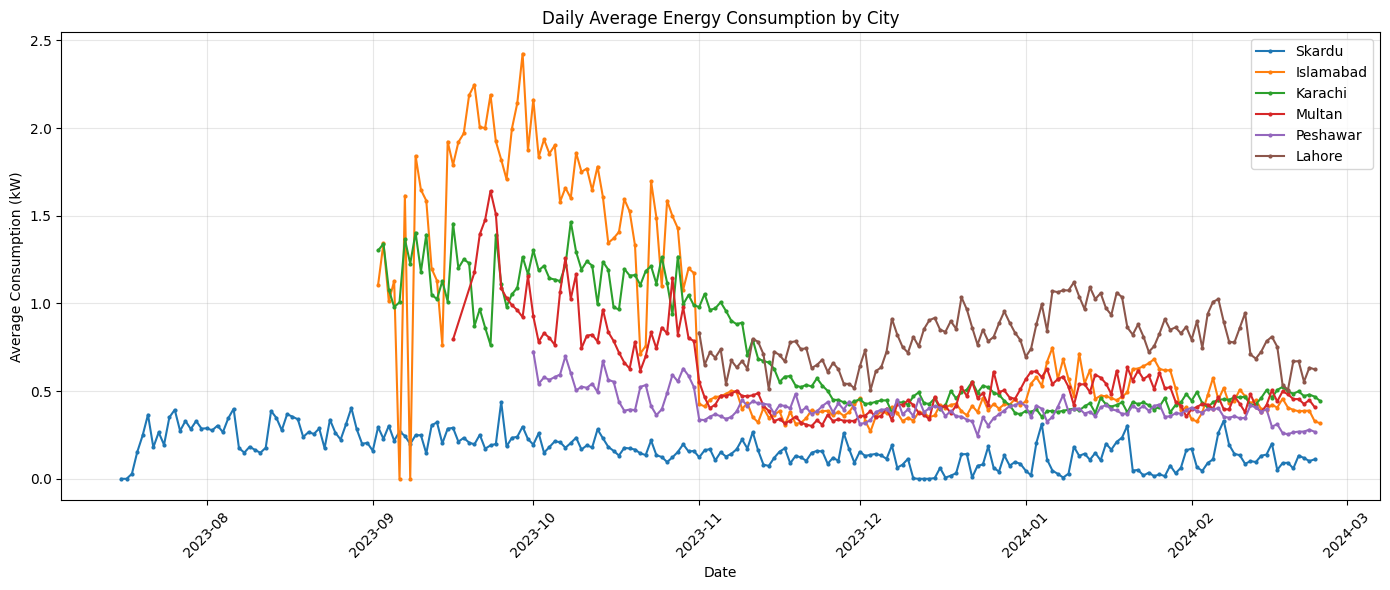


2. Weather-Energy Correlations


25/11/12 22:28:42 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:42 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:42 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 45.5 MiB so far)
25/11/12 22:28:42 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:43 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:43 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:43 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:28:43 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 79.1 MiB so far)
25/11/12 22:28:44 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 79.1 MiB so far)
25/11/12 

   Saved: gold_data/weather_correlations.png


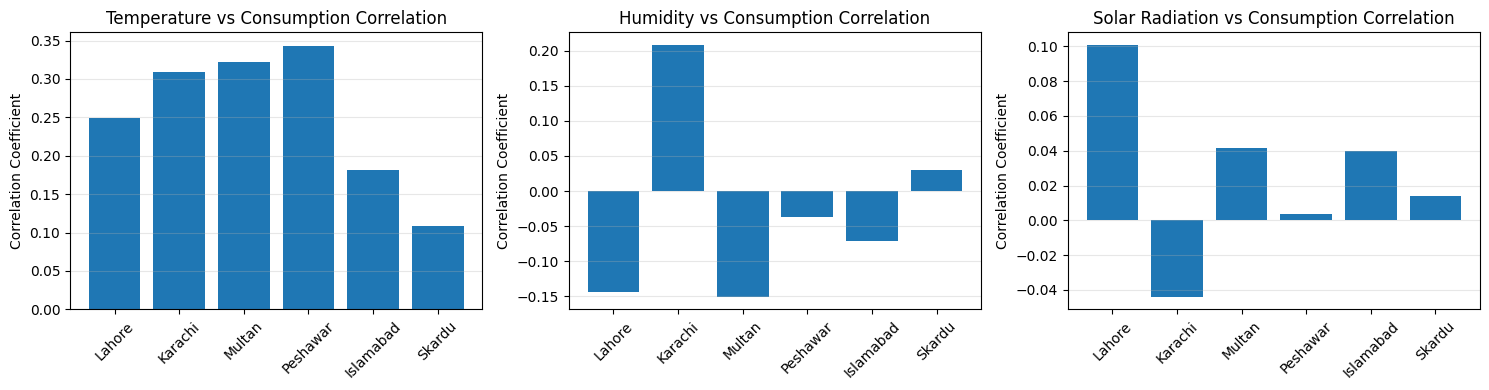


3. Hourly Consumption Patterns


   Saved: gold_data/hourly_patterns.png


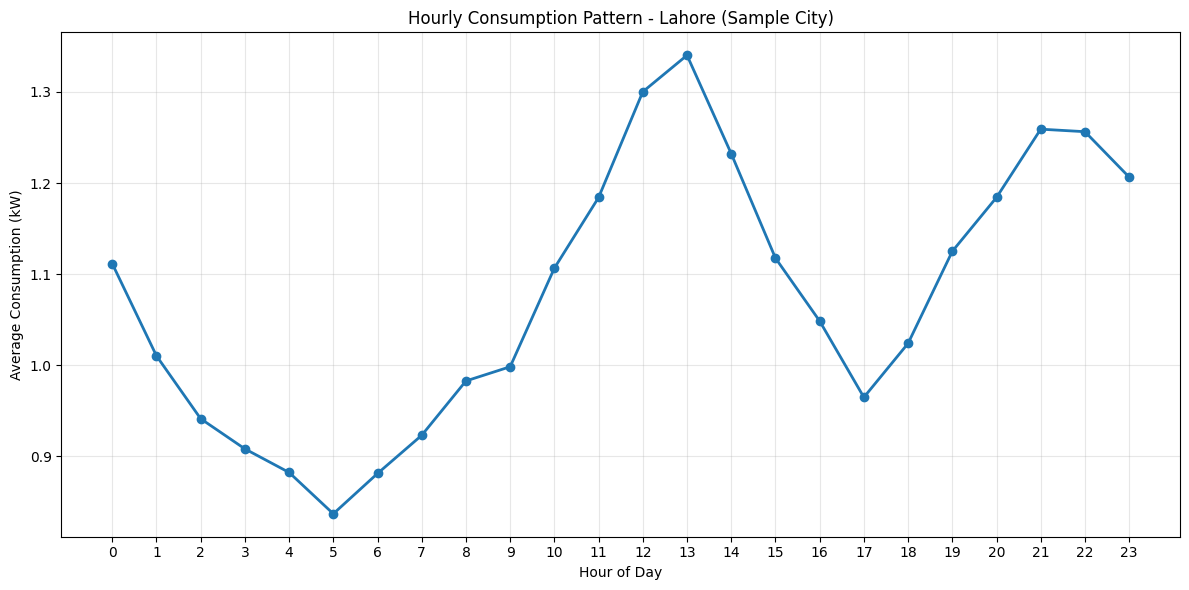


4. Peak Demand by Temperature Range


25/11/12 22:29:02 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:02 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:02 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:03 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:03 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:03 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:03 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:03 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:03 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 79.1 MiB so far)
25/11/12 

   Saved: gold_data/peak_demand_by_temp.png


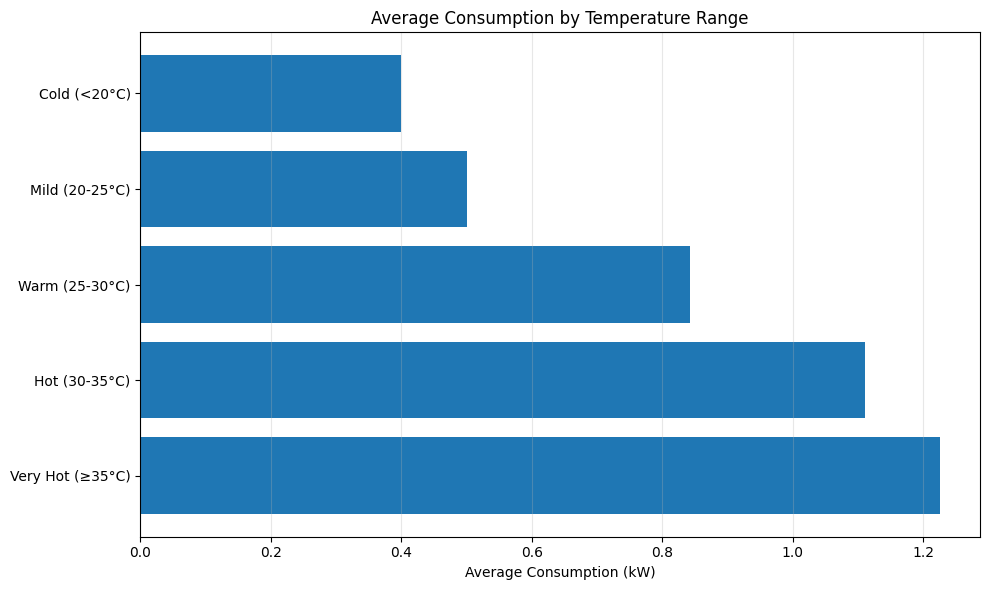


5. Household Clusters Distribution


25/11/12 22:29:05 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:05 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:05 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:05 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:05 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:06 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:06 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:06 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:06 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12

   Saved: gold_data/household_clusters.png


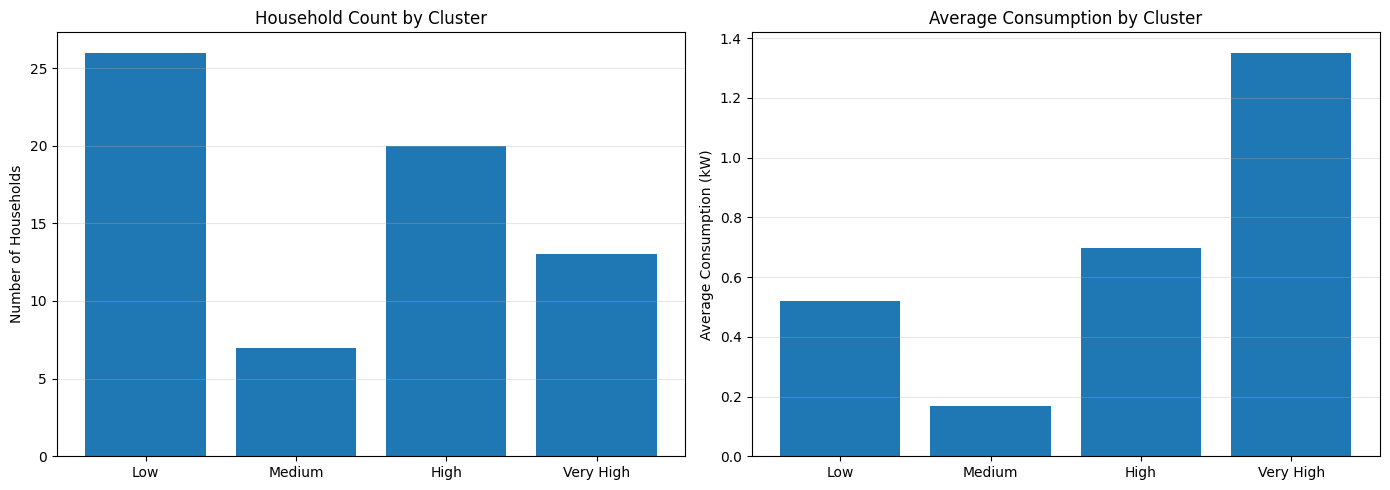


6. ML Model Performance - Prediction vs Actual (Sample)


   Saved: gold_data/ml_model_performance.png


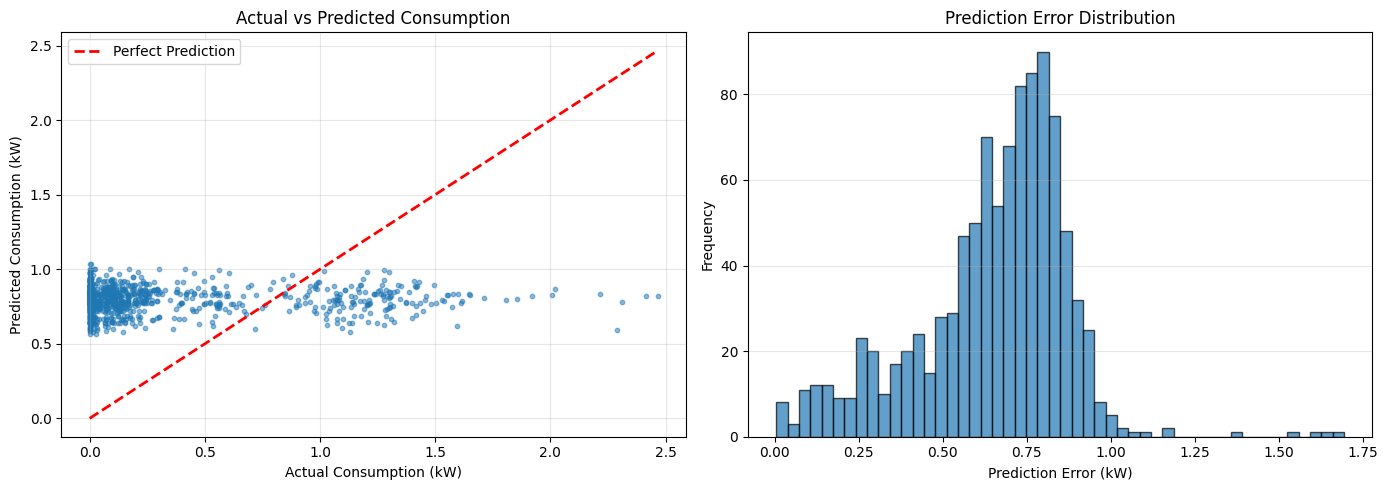


Visualization Summary:
  All visualizations saved to gold_data/ directory
  Files created:
    - daily_consumption_trends.png
    - weather_correlations.png
    - hourly_patterns.png
    - peak_demand_by_temp.png
    - household_clusters.png
    - ml_model_performance.png

Note: For interactive dashboards, consider using:
  - Plotly for interactive web visualizations
  - Tableau/Power BI for business dashboards
  - Jupyter widgets for interactive exploration


In [7]:
# Data Visualizations
# Note: For production dashboards, use tools like Plotly, Matplotlib, or Tableau
# This section creates sample visualizations using pandas and matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pyspark.sql.functions import col, abs

# Create gold_data directory if it doesn't exist
os.makedirs("gold_data", exist_ok=True)

print("=== Creating Data Visualizations ===\n")

# Convert Spark DataFrames to Pandas for visualization (sample data)
print("1. Daily Consumption Trends by City")
daily_pd = daily_metrics.orderBy("date", "city").limit(1000).toPandas()
if len(daily_pd) > 0:
    # Convert date column to datetime if it's not already
    if 'date' in daily_pd.columns:
        daily_pd['date'] = pd.to_datetime(daily_pd['date'])
    
    fig, ax = plt.subplots(figsize=(14, 6))
    for city in daily_pd['city'].unique():
        city_data = daily_pd[daily_pd['city'] == city]
        if len(city_data) > 0:
            ax.plot(city_data['date'], city_data['avg_consumption_kw'], label=city, marker='o', markersize=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Consumption (kW)')
    ax.set_title('Daily Average Energy Consumption by City')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('gold_data/daily_consumption_trends.png', dpi=150, bbox_inches='tight')
    print("   Saved: gold_data/daily_consumption_trends.png")
    plt.show()  # Display in notebook
    plt.close()
else:
    print("   No data available for visualization")

print("\n2. Weather-Energy Correlations")
weather_corr_pd = weather_correlation.toPandas()
if len(weather_corr_pd) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Temperature correlation
    axes[0].bar(weather_corr_pd['city'], weather_corr_pd['temp_consumption_corr'])
    axes[0].set_title('Temperature vs Consumption Correlation')
    axes[0].set_ylabel('Correlation Coefficient')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Humidity correlation
    axes[1].bar(weather_corr_pd['city'], weather_corr_pd['humidity_consumption_corr'])
    axes[1].set_title('Humidity vs Consumption Correlation')
    axes[1].set_ylabel('Correlation Coefficient')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Solar radiation correlation
    axes[2].bar(weather_corr_pd['city'], weather_corr_pd['solar_consumption_corr'])
    axes[2].set_title('Solar Radiation vs Consumption Correlation')
    axes[2].set_ylabel('Correlation Coefficient')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('gold_data/weather_correlations.png', dpi=150, bbox_inches='tight')
    print("   Saved: gold_data/weather_correlations.png")
    plt.show()  # Display in notebook
    plt.close()

print("\n3. Hourly Consumption Patterns")
hourly_pd = hourly_patterns.filter(col("city") == "Lahore").toPandas()
if len(hourly_pd) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(hourly_pd['hour_of_day'], hourly_pd['avg_consumption_kw'], marker='o', linewidth=2, markersize=6)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Consumption (kW)')
    ax.set_title('Hourly Consumption Pattern - Lahore (Sample City)')
    ax.set_xticks(range(0, 24))
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('gold_data/hourly_patterns.png', dpi=150, bbox_inches='tight')
    print("   Saved: gold_data/hourly_patterns.png")
    plt.show()  # Display in notebook
    plt.close()

print("\n4. Peak Demand by Temperature Range")
peak_pd = peak_demand.toPandas()
if len(peak_pd) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(peak_pd['temperature_range'], peak_pd['avg_consumption_kw'])
    ax.set_xlabel('Average Consumption (kW)')
    ax.set_title('Average Consumption by Temperature Range')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('gold_data/peak_demand_by_temp.png', dpi=150, bbox_inches='tight')
    print("   Saved: gold_data/peak_demand_by_temp.png")
    plt.show()  # Display in notebook
    plt.close()

print("\n5. Household Clusters Distribution")
cluster_summary_pd = cluster_summary.toPandas()
if len(cluster_summary_pd) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Cluster count
    cluster_labels = ['Low', 'Medium', 'High', 'Very High']
    axes[0].bar(cluster_labels[:len(cluster_summary_pd)], cluster_summary_pd['household_count'])
    axes[0].set_title('Household Count by Cluster')
    axes[0].set_ylabel('Number of Households')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Average consumption by cluster
    axes[1].bar(cluster_labels[:len(cluster_summary_pd)], cluster_summary_pd['avg_cluster_consumption'])
    axes[1].set_title('Average Consumption by Cluster')
    axes[1].set_ylabel('Average Consumption (kW)')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('gold_data/household_clusters.png', dpi=150, bbox_inches='tight')
    print("   Saved: gold_data/household_clusters.png")
    plt.show()  # Display in notebook
    plt.close()

print("\n6. ML Model Performance - Prediction vs Actual (Sample)")
# Sample predictions for visualization
# Create gold_predictions from predictions DataFrame (from Step 5 ML)
# predictions DataFrame already contains datetime, usage_kw, prediction, and other columns
try:
    # Check if predictions DataFrame exists and has required columns
    if 'predictions' in globals() and predictions is not None:
        # Select available columns (datetime should be in predictions from ml_data)
        available_cols = predictions.columns
        select_cols = []
        if "datetime" in available_cols:
            select_cols.append("datetime")
        if "city" in available_cols:
            select_cols.append("city")
        select_cols.extend(["usage_kw", "prediction"])
        if "Temperature" in available_cols:
            select_cols.append("Temperature")
        if "Humidity" in available_cols:
            select_cols.append("Humidity")
        if "Solar Radiation" in available_cols:
            select_cols.append("Solar Radiation")
        
        gold_predictions_viz = predictions.select(*select_cols).withColumn(
            "prediction_error", abs(col("usage_kw") - col("prediction"))
        )
        pred_sample = gold_predictions_viz.limit(1000).toPandas()
    else:
        pred_sample = pd.DataFrame()  # Empty DataFrame if predictions doesn't exist
except Exception as e:
    print(f"   Warning: Could not create prediction visualization: {e}")
    pred_sample = pd.DataFrame()
if len(pred_sample) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: Actual vs Predicted
    axes[0].scatter(pred_sample['usage_kw'], pred_sample['prediction'], alpha=0.5, s=10)
    axes[0].plot([pred_sample['usage_kw'].min(), pred_sample['usage_kw'].max()], 
                  [pred_sample['usage_kw'].min(), pred_sample['usage_kw'].max()], 
                  'r--', linewidth=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Consumption (kW)')
    axes[0].set_ylabel('Predicted Consumption (kW)')
    axes[0].set_title('Actual vs Predicted Consumption')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution
    axes[1].hist(pred_sample['prediction_error'], bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Prediction Error (kW)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Prediction Error Distribution')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('gold_data/ml_model_performance.png', dpi=150, bbox_inches='tight')
    print("   Saved: gold_data/ml_model_performance.png")
    plt.show()  # Display in notebook
    plt.close()
else:
    print("   No prediction data available for visualization")

print("\n" + "="*60)
print("Visualization Summary:")
print("  All visualizations saved to gold_data/ directory")
print("  Files created:")
print("    - daily_consumption_trends.png")
print("    - weather_correlations.png")
print("    - hourly_patterns.png")
print("    - peak_demand_by_temp.png")
print("    - household_clusters.png")
print("    - ml_model_performance.png")
print("\nNote: For interactive dashboards, consider using:")
print("  - Plotly for interactive web visualizations")
print("  - Tableau/Power BI for business dashboards")
print("  - Jupyter widgets for interactive exploration")


## Step 7: Prepare Data for Serving (Gold Layer)

Format and save analytics-ready datasets for dashboards, applications, and reporting.


In [8]:
# Create final Gold layer datasets for serving
import os

# Create output directory
os.makedirs("gold_data", exist_ok=True)

print("=== Saving Gold Layer Datasets ===\n")

# 1. Daily Energy Consumption Metrics (for dashboards)
print("1. Saving daily energy consumption metrics...")
gold_daily_metrics = daily_metrics.coalesce(1)
gold_daily_metrics.write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv("gold_data/daily_consumption_metrics")
print("   Saved to: gold_data/daily_consumption_metrics/")

# 2. Weather-Energy Correlations (for analysis)
print("\n2. Saving weather-energy correlations...")
gold_weather_corr = weather_correlation.coalesce(1)
gold_weather_corr.write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv("gold_data/weather_energy_correlations")
print("   Saved to: gold_data/weather_energy_correlations/")

# 3. Peak Demand Analysis (for demand forecasting)
print("\n3. Saving peak demand analysis...")
gold_peak_demand = peak_demand.coalesce(1)
gold_peak_demand.write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv("gold_data/peak_demand_analysis")
print("   Saved to: gold_data/peak_demand_analysis/")

# 4. Monthly Trends (for reporting)
print("\n4. Saving monthly trend analysis...")
gold_monthly_trends = monthly_trends.coalesce(1)
gold_monthly_trends.write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv("gold_data/monthly_trends")
print("   Saved to: gold_data/monthly_trends/")

# 5. Household Summary (for household-level analytics)
print("\n5. Saving household consumption summary...")
gold_household_summary = household_summary.coalesce(1)
gold_household_summary.write \
    .mode("overwrite") \
    .parquet("gold_data/household_summary")
print("   Saved to: gold_data/household_summary/ (Parquet)")

# 6. Clustered Households (for ML serving and targeting)
print("\n6. Saving household clusters...")
gold_clustered_households = clustered_households.select(
    "city", "source_file", "avg_consumption", "peak_consumption", 
    "consumption_variability", "prediction"
).coalesce(1)
gold_clustered_households.write \
    .mode("overwrite") \
    .parquet("gold_data/household_clusters")
print("   Saved to: gold_data/household_clusters/ (Parquet)")

# 7. ML Model Predictions (for consumption forecasting)
print("\n7. Saving ML predictions...")
# Join predictions back with datetime from test_data
# test_data has datetime, predictions has prediction column
test_with_datetime = test_data.select("datetime", "usage_kw", "Temperature", "Humidity", "Solar Radiation", "city")
predictions_with_datetime = predictions.select("prediction").withColumn("row_id", monotonically_increasing_id())
test_with_datetime = test_with_datetime.withColumn("row_id", monotonically_increasing_id())

gold_predictions = test_with_datetime.join(
    predictions_with_datetime, 
    on="row_id", 
    how="inner"
).select(
    "datetime", "city", "usage_kw", "prediction", "Temperature", 
    "Humidity", "Solar Radiation"
).withColumn("prediction_error", abs(col("usage_kw") - col("prediction"))) \
 .drop("row_id") \
 .coalesce(1)

gold_predictions.write \
    .mode("overwrite") \
    .parquet("gold_data/consumption_predictions")
print("   Saved to: gold_data/consumption_predictions/ (Parquet)")

# 8. Hourly Patterns (for time-of-use analysis)
print("\n8. Saving hourly consumption patterns...")
gold_hourly_patterns = hourly_patterns.coalesce(1)
gold_hourly_patterns.write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv("gold_data/hourly_patterns")
print("   Saved to: gold_data/hourly_patterns/")

print("\n" + "="*60)
print("=== Gold Layer Summary ===")
print("="*60)
print("All analytics-ready datasets saved to gold_data/")
print("\nDatasets created:")
print("  1. Daily consumption metrics (CSV)")
print("  2. Weather-energy correlations (CSV)")
print("  3. Peak demand analysis (CSV)")
print("  4. Monthly trends (CSV)")
print("  5. Household summary (Parquet)")
print("  6. Household clusters (Parquet)")
print("  7. Consumption predictions (Parquet)")
print("  8. Hourly patterns (CSV)")
print("\nReady for dashboard/app consumption!")


=== Saving Gold Layer Datasets ===

1. Saving daily energy consumption metrics...


   Saved to: gold_data/daily_consumption_metrics/

2. Saving weather-energy correlations...


25/11/12 22:29:39 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:39 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:39 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:39 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:40 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:40 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:40 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 23.1 MiB so far)
25/11/12 22:29:40 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:40 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 45.5 MiB so far)
25/11/

   Saved to: gold_data/weather_energy_correlations/

3. Saving peak demand analysis...


25/11/12 22:29:42 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:42 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:42 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:42 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:43 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:43 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:43 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:29:43 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 23.1 MiB so far)
25/11/12 22:29:43 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed 79.1 MiB so far)
25/11/1

   Saved to: gold_data/peak_demand_analysis/

4. Saving monthly trend analysis...


25/11/12 22:29:45 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:46 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:46 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:46 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:46 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:47 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:47 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 45.5 MiB so far)
25/11/12 22:29:48 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 79.1 MiB so far)
25/11/12 22:29:48 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 79.1 MiB so far)
25/11/

   Saved to: gold_data/monthly_trends/

5. Saving household consumption summary...


   Saved to: gold_data/household_summary/ (Parquet)

6. Saving household clusters...


25/11/12 22:30:16 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 23.1 MiB so far)
25/11/12 22:30:16 WARN MemoryStore: Not enough space to cache rdd_170_6 in memory! (computed 23.1 MiB so far)
25/11/12 22:30:17 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 79.1 MiB so far)
25/11/12 22:30:17 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 11.9 MiB so far)
25/11/12 22:30:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_170_10 in memory.
25/11/12 22:30:17 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 384.0 B so far)
25/11/12 22:30:17 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 45.5 MiB so far)
25/11/12 22:30:18 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 23.1 MiB so far)
25/11/12 22:30:18 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed

   Saved to: gold_data/household_clusters/ (Parquet)

7. Saving ML predictions...


25/11/12 22:30:20 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 45.5 MiB so far)
25/11/12 22:30:20 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 45.5 MiB so far)
25/11/12 22:30:29 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:30:38 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 45.5 MiB so far)
25/11/12 22:30:42 WARN MemoryStore: Not enough space to cache rdd_170_23 in memory! (computed 79.2 MiB so far)
25/11/12 22:30:55 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 79.1 MiB so far)
25/11/12 22:30:55 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 79.2 MiB so far)
25/11/12 22:31:03 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 23.1 MiB so far)
25/11/12 22:31:06 WARN MemoryStore: Not enough space to cache rdd_170_23 in memory! (computed 23.1 MiB so far)
   

   Saved to: gold_data/consumption_predictions/ (Parquet)

8. Saving hourly consumption patterns...


[Stage 260:====================================================>  (24 + 1) / 25]

   Saved to: gold_data/hourly_patterns/

=== Gold Layer Summary ===
All analytics-ready datasets saved to gold_data/

Datasets created:
  1. Daily consumption metrics (CSV)
  2. Weather-energy correlations (CSV)
  3. Peak demand analysis (CSV)
  4. Monthly trends (CSV)
  5. Household summary (Parquet)
  6. Household clusters (Parquet)
  7. Consumption predictions (Parquet)
  8. Hourly patterns (CSV)

Ready for dashboard/app consumption!


## Step 7: Performance Profiling and Tuning

Profile SQL and MLlib operations, measure execution times, and document optimization strategies.


In [12]:
# Performance Profiling
import time
import builtins

print("=== Performance Profiling ===")
print("Measuring execution time for each major operation...\n")

operations = {
    '1. Data Loading (Silver)': lambda: silver_df.count(),
    '2. Data Loading (Weather)': lambda: weather_df.count(),
    '3. Data Join (Energy + Weather)': lambda: joined_df.count(),
    '4. Daily Metrics SQL': lambda: daily_metrics.count(),
    '5. Weather Correlation SQL': lambda: weather_correlation.count(),
    '6. Monthly Trends (Window Functions)': lambda: monthly_trends.count(),
    '7. Linear Regression Training': lambda: train_data.count(),
    '8. Linear Regression Prediction': lambda: predictions.count(),
    '9. K-Means Clustering': lambda: clustered_households.count()
}

profiling_results = {}
for op_name, op_func in operations.items():
    start_time = time.time()
    result = op_func()
    elapsed = time.time() - start_time
    profiling_results[op_name] = {
        'time': elapsed,
        'records': result
    }
    print(f"{op_name}:")
    print(f"  Time: {elapsed:.3f} seconds")
    print(f"  Records: {result:,}")
    if result > 0:
        throughput = result / elapsed
        print(f"  Throughput: {throughput:,.0f} records/second")
    print()

# Calculate total processing time
total_time = builtins.sum(r['time'] for r in profiling_results.values())
print(f"Total Processing Time: {total_time:.3f} seconds ({total_time/60:.2f} minutes)")

# Throughput Summary
print("\n=== Throughput Summary ===")
for op_name, results in profiling_results.items():
    if results['records'] > 0:
        throughput = results['records'] / results['time']
        print(f"{op_name}: {throughput:,.0f} records/second")

# Optimization Analysis
print("\n=== Optimization Analysis ===")
slowest_op = builtins.max(profiling_results.items(), key=lambda x: x[1]['time'])
print(f"Slowest operation: {slowest_op[0]} ({slowest_op[1]['time']:.3f}s)")
print(f"Recommendation: Focus optimization efforts on {slowest_op[0]}")

# Optimization Recommendations
print("\n=== Optimization Recommendations ===")
print("1. ✅ Parquet format: Used for large datasets (household_summary, clusters, predictions)")
print("2. ✅ Caching: Applied to joined_df for multiple uses")
print("3. ✅ Adaptive Query Execution: Enabled (spark.sql.adaptive.enabled=true)")
print("4. ✅ Skew Join Handling: Enabled (spark.sql.adaptive.skewJoin.enabled=true)")
print("5. ✅ Partition Tuning: spark.sql.shuffle.partitions=200")
print("6. Monitor Spark UI: http://localhost:4040")
print("7. Consider broadcast joins for small weather lookup tables")
print("8. Partition data by date/city for better query performance")

# Cache Statistics
print("\n=== Caching Statistics ===")
if joined_df.is_cached:
    print("joined_df is cached")
    print(f"  Cached records: {joined_df.count():,}")
    print("  Benefits: Faster subsequent queries on joined data")

# Warning Explanations
print("\n=== Warning Explanations ===")
print("Memory Warnings (Not enough space to cache):")
print("  - These are informational warnings, not errors")
print("  - Spark automatically uses disk when memory is full")
print("  - Normal behavior for large datasets on VMs with limited RAM")
print("  - Performance may be slower but processing will complete")
print("\nNative Library Warnings:")
print("  - 'Unable to load native-hadoop library': Normal on Windows/VM")
print("  - 'Failed to load JNILAPACK': Falls back to Java implementation")
print("  - These do not affect functionality, just use slower Java libraries")
print("\nLinear Regression Warning:")
print("  - 'regParam is zero': Fixed by adding regParam=0.01")
print("  - Prevents numerical instability and overfitting")

print("\nPerformance profiling complete")


=== Performance Profiling ===
Measuring execution time for each major operation...



1. Data Loading (Silver):
  Time: 16.920 seconds
  Records: 27,986,366
  Throughput: 1,654,024 records/second

2. Data Loading (Weather):
  Time: 0.147 seconds
  Records: 74,736
  Throughput: 508,587 records/second



25/11/12 22:47:05 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 45.5 MiB so far)
25/11/12 22:47:05 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 79.2 MiB so far)
25/11/12 22:47:05 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 23.1 MiB so far)
25/11/12 22:47:05 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 11.9 MiB so far)
25/11/12 22:47:06 WARN MemoryStore: Not enough space to cache rdd_170_8 in memory! (computed 45.5 MiB so far)
25/11/12 22:47:06 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:06 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 23.1 MiB so far)
25/11/12 22:47:06 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 45.5 MiB so far)
25/11/12 22:47:06 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed 45.5 MiB so far)
25/1

3. Data Join (Energy + Weather):
  Time: 1.244 seconds
  Records: 27,986,366
  Throughput: 22,499,615 records/second



4. Daily Metrics SQL:
  Time: 26.347 seconds
  Records: 2,531
  Throughput: 96 records/second



25/11/12 22:47:33 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 79.2 MiB so far)
25/11/12 22:47:33 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:33 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 45.5 MiB so far)
25/11/12 22:47:33 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:34 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 45.5 MiB so far)
25/11/12 22:47:34 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 45.5 MiB so far)
25/11/12 22:47:34 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:34 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 45.5 MiB so far)
25/11/12 22:47:34 WARN MemoryStore: Not enough space to cache rdd_170_18 in memory! (computed 45.5 MiB so far)
25/1

5. Weather Correlation SQL:
  Time: 2.240 seconds
  Records: 6
  Throughput: 3 records/second



25/11/12 22:47:35 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 79.2 MiB so far)
25/11/12 22:47:35 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:35 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:36 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:36 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:37 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 11.9 MiB so far)
25/11/12 22:47:37 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 79.1 MiB so far)
25/11/12 22:47:37 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 79.2 MiB so far)
25/11/12 22:47:37 WARN MemoryStore: Not enough space to cache rdd_170_16 in memory! (computed 11.9 MiB so far)
25/11

6. Monthly Trends (Window Functions):
  Time: 4.740 seconds
  Records: 85
  Throughput: 18 records/second



25/11/12 22:47:55 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 79.1 MiB so far)
                                                                                

7. Linear Regression Training:
  Time: 23.434 seconds
  Records: 22,390,638
  Throughput: 955,491 records/second



25/11/12 22:48:19 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 79.1 MiB so far)
                                                                                

8. Linear Regression Prediction:
  Time: 23.224 seconds
  Records: 5,595,728
  Throughput: 240,948 records/second



25/11/12 22:48:27 WARN MemoryStore: Not enough space to cache rdd_170_4 in memory! (computed 79.1 MiB so far)
25/11/12 22:48:27 WARN MemoryStore: Not enough space to cache rdd_170_5 in memory! (computed 45.5 MiB so far)
25/11/12 22:48:27 WARN MemoryStore: Not enough space to cache rdd_170_7 in memory! (computed 23.1 MiB so far)
25/11/12 22:48:27 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 45.5 MiB so far)
25/11/12 22:48:27 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 23.1 MiB so far)
25/11/12 22:48:27 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 79.1 MiB so far)
25/11/12 22:48:28 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 11.9 MiB so far)
25/11/12 22:48:28 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 79.1 MiB so far)
25/11/12 22:48:28 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 79.1 MiB so far)
25/11

9. K-Means Clustering:
  Time: 3.833 seconds
  Records: 66
  Throughput: 17 records/second

Total Processing Time: 102.130 seconds (1.70 minutes)

=== Throughput Summary ===
1. Data Loading (Silver): 1,654,024 records/second
2. Data Loading (Weather): 508,587 records/second
3. Data Join (Energy + Weather): 22,499,615 records/second
4. Daily Metrics SQL: 96 records/second
5. Weather Correlation SQL: 3 records/second
6. Monthly Trends (Window Functions): 18 records/second
7. Linear Regression Training: 955,491 records/second
8. Linear Regression Prediction: 240,948 records/second
9. K-Means Clustering: 17 records/second

=== Optimization Analysis ===
Slowest operation: 4. Daily Metrics SQL (26.347s)
Recommendation: Focus optimization efforts on 4. Daily Metrics SQL

=== Optimization Recommendations ===
1. ✅ Parquet format: Used for large datasets (household_summary, clusters, predictions)
2. ✅ Caching: Applied to joined_df for multiple uses
3. ✅ Adaptive Query Execution: Enabled (spark.s

25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_9 in memory! (computed 79.1 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_11 in memory! (computed 23.1 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_13 in memory! (computed 23.1 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_10 in memory! (computed 45.5 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_12 in memory! (computed 79.1 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_15 in memory! (computed 23.1 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_18 in memory! (computed 23.1 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_14 in memory! (computed 45.5 MiB so far)


  Cached records: 27,986,366
  Benefits: Faster subsequent queries on joined data

=== Warning Explanations ===
Memory Warnings (Not enough space to cache):
  - These are informational warnings, not errors
  - Spark automatically uses disk when memory is full
  - Normal behavior for large datasets on VMs with limited RAM
  - Performance may be slower but processing will complete

Native Library Warnings:
  - 'Unable to load native-hadoop library': Normal on Windows/VM
  - 'Failed to load JNILAPACK': Falls back to Java implementation
  - These do not affect functionality, just use slower Java libraries

Linear Regression Warning:
  - 'regParam is zero': Fixed by adding regParam=0.01
  - Prevents numerical instability and overfitting

Performance profiling complete


25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_17 in memory! (computed 79.2 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_19 in memory! (computed 23.1 MiB so far)
25/11/12 22:48:30 WARN MemoryStore: Not enough space to cache rdd_170_21 in memory! (computed 79.1 MiB so far)
                                                                                

## Summary

### Analytics Completed:
1. **Weather-Energy Integration**: Joined weather data with energy consumption data
2. **Business Metrics (SQL)**: Daily consumption, hourly patterns, peak demand analysis
3. **Weather Correlations**: Temperature, humidity, solar radiation correlations with consumption
4. **Time-Series Analysis**: Rolling averages, monthly trends, peak demand identification
5. **Machine Learning**:
   - Linear Regression for consumption prediction (RMSE, R² metrics)
   - K-Means Clustering for household segmentation (4 clusters)
6. **Data Serving**: 8 analytics-ready datasets saved to Gold layer
7. **Performance Profiling**: Execution times, throughput analysis, optimization recommendations

### Gold Layer Outputs:
- `daily_consumption_metrics/` - Daily energy consumption by city (CSV)
- `weather_energy_correlations/` - Weather-consumption correlations (CSV)
- `peak_demand_analysis/` - Peak demand by temperature ranges (CSV)
- `monthly_trends/` - Monthly consumption trends with growth rates (CSV)
- `household_summary/` - Household-level consumption statistics (Parquet)
- `household_clusters/` - Household clusters for targeting (Parquet)
- `consumption_predictions/` - ML model predictions for forecasting (Parquet)
- `hourly_patterns/` - Hourly consumption patterns by city (CSV)

### Key Results:
- **Data Processed**: ~28M energy records + weather data
- **ML Model Performance**: RMSE and R² scores calculated
- **Household Clusters**: 4 consumption-based segments identified
- **Weather Correlations**: Temperature, humidity, solar radiation correlations analyzed
- **Processing**: Efficient SQL and MLlib operations with adaptive execution


In [13]:
# Cleanup
joined_df.unpersist()

spark.stop()
print("Spark session stopped")
print("\n=== Part 3 Complete ===")
print("Gold layer datasets ready for dashboard/app consumption!")


25/11/12 22:50:54 WARN BlockManager: Block rdd_170_19 could not be removed as it was not found on disk or in memory


Spark session stopped

=== Part 3 Complete ===
Gold layer datasets ready for dashboard/app consumption!
